In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

## Functions

### Plot method

In [83]:
def plot_vote_share_vs_population(df, population_col, dem_col, rep_col, degree, region_type=None):
    """
    Plots vote share (Democratic and Republican) vs population percentage with optional region filtering.

    Parameters:
    - df: pd.DataFrame containing the data.
    - population_col: str, column name for population percentage.
    - dem_col: str, column name for Democratic vote share.
    - rep_col: str, column name for Republican vote share.
    - degree: int, degree of the polynomial fit.
    - region_type: str or None, filters data based on region type. If 'all' or None, no filtering.
    """
    # Filter by region type if specified
    if region_type and region_type.lower() != 'all':
        df = df[df['REGION_TYPE'].str.lower() == region_type.lower()]
    
    # Check if the filtered DataFrame is empty
    if df.empty:
        print(f"No data available for REGION_TYPE: {region_type}")
        return
    
    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x=population_col,
        y=dem_col,
        color='blue',
        label='Democratic Vote Share',
        alpha=0.6
    )
    sns.scatterplot(
        data=df,
        x=population_col,
        y=rep_col,
        color='red',
        label='Republican Vote Share',
        alpha=0.6
    )

    # Fit polynomial lines
    democratic_poly = Polynomial.fit(df[population_col], df[dem_col], deg=degree)
    x_vals = np.linspace(df[population_col].min(), df[population_col].max(), 100)
    plt.plot(x_vals, democratic_poly(x_vals), color='blue', label='Democratic Line')

    republican_poly = Polynomial.fit(df[population_col], df[rep_col], deg=degree)
    plt.plot(x_vals, republican_poly(x_vals), color='red', label='Republican Line')

    # Customize plot
    title_region = f" for Region Type: {region_type.capitalize()}" if region_type and region_type.lower() != 'all' else ""
    plt.title(f'Non-Linear Vote Share vs Population Percentage{title_region}', fontsize=16)
    plt.xlabel(f'{population_col}', fontsize=14)
    plt.ylabel('Vote Share', fontsize=14)
    plt.legend(title="Vote Share", fontsize=12)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

### Main Function and declaration

In [49]:
brackets = {
    "0_35K": 17500,
    "35K_60K": 47500,
    "60K_100K": 80000,
    "100K_125K": 112500,
    "125K_150K": 137500,
    "150K_MORE": 150000
}

In [50]:
def calculate_avg_income(row):
    total_income = 0
    total_households = 0
    for bracket, midpoint in brackets.items():
        total_income += row[bracket] * midpoint
        total_households += row[bracket]
    return total_income / total_households if total_households > 0 else 0

In [74]:
def process_population_vote_share(race_df, election_df, region_type_df, econ_df, target_population_col_name, population_col):

    election_df['REPUBLICAN_VOTE_SHARE'] = (election_df['TOT_REP'] / election_df['TOT_VOT']) * 100
    election_df['DEMOCRATIC_VOTE_SHARE'] = (election_df['TOT_DEM'] / election_df['TOT_VOT']) * 100
    race_df[target_population_col_name] = (race_df[population_col] / race_df['TOT_POP22']) * 100
    econ_df['AVG_HOUSEHOLD_INCOME'] = econ_df.apply(calculate_avg_income, axis=1)

    merged_df = pd.merge(election_df, race_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, region_type_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, econ_df, on='UNIQUE_ID', how='inner')

    columns_to_keep = ['UNIQUE_ID', 'REPUBLICAN_VOTE_SHARE', 'DEMOCRATIC_VOTE_SHARE', target_population_col_name, 'AVG_HOUSEHOLD_INCOME', 'REGION_TYPE']
    merged_df = merged_df[columns_to_keep]
    merged_df = merged_df.dropna(subset=[target_population_col_name, 'REPUBLICAN_VOTE_SHARE', 'DEMOCRATIC_VOTE_SHARE'])
    # remove outliers
    merged_df = merged_df[(merged_df[target_population_col_name] != 0.0) & (merged_df[target_population_col_name] != 100.0)]
    merged_df = merged_df[(merged_df['REPUBLICAN_VOTE_SHARE'] != 0.0) & (merged_df['REPUBLICAN_VOTE_SHARE'] != 100.0)]
    merged_df = merged_df[(merged_df['DEMOCRATIC_VOTE_SHARE'] != 0.0) & (merged_df['DEMOCRATIC_VOTE_SHARE'] != 100.0)]
    return merged_df

In [77]:
def process_income_vote_share(election_df, region_type_df, econ_df):
    # Calculate vote shares
    election_df['REPUBLICAN_VOTE_SHARE'] = (election_df['TOT_REP'] / election_df['TOT_VOT']) * 100
    election_df['DEMOCRATIC_VOTE_SHARE'] = (election_df['TOT_DEM'] / election_df['TOT_VOT']) * 100
    
    # Calculate average household income
    econ_df['AVG_HOUSEHOLD_INCOME'] = econ_df.apply(calculate_avg_income, axis=1)

    # Merge dataframes
    merged_df = pd.merge(election_df, region_type_df, on='UNIQUE_ID', how='inner')
    merged_df = pd.merge(merged_df, econ_df, on='UNIQUE_ID', how='inner')

    # Keep necessary columns
    columns_to_keep = ['UNIQUE_ID', 'REPUBLICAN_VOTE_SHARE', 'DEMOCRATIC_VOTE_SHARE', 'AVG_HOUSEHOLD_INCOME', 'REGION_TYPE']
    merged_df = merged_df[columns_to_keep]

    # Drop NaNs
    merged_df = merged_df.dropna(subset=['REPUBLICAN_VOTE_SHARE', 'DEMOCRATIC_VOTE_SHARE', 'AVG_HOUSEHOLD_INCOME'])

    # Remove outliers
    merged_df = merged_df[(merged_df['REPUBLICAN_VOTE_SHARE'] != 0.0) & (merged_df['REPUBLICAN_VOTE_SHARE'] != 100.0)]
    merged_df = merged_df[(merged_df['DEMOCRATIC_VOTE_SHARE'] != 0.0) & (merged_df['DEMOCRATIC_VOTE_SHARE'] != 100.0)]
    merged_df = merged_df[(merged_df['AVG_HOUSEHOLD_INCOME'] != 0.0)]

    return merged_df


# South Carolina

## Import data

In [78]:
sc_election_gov_df = pd.read_json('states/south_carolina/election/sc_election_gov_22.json')
sc_race_df = pd.read_json('states/south_carolina/demographics/south_carolina_precincts_racial_population.json')
sc_region_type_df = pd.read_json('states/south_carolina/geodata/south_carolina_precincts_region_type.json')
sc_econ_df = pd.read_json('states/south_carolina/economic/south_carolina_precincts_household_income.json')

In [79]:
# change region_type column to REGION_TYPE
sc_region_type_df = sc_region_type_df.rename(columns={'region_type': 'REGION_TYPE'})

## Main script

In [80]:
print(sc_race_df.columns)

Index(['UNIQUE_ID', 'NAME', 'Prec_Code', 'CONG_DIST', 'TOT_POP22',
       'NHSP_POP22', 'HSP_POP22', 'WHT_NHSP22', 'BLK_NHSP22', 'ASN_NHSP22',
       'OTH_NHSP22'],
      dtype='object')


In [81]:
sc_white_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'WHITE_PERCENT', 'WHT_NHSP22')
sc_black_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'BLACK_PERCENT', 'BLK_NHSP22')
sc_asian_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'ASIAN_PERCENT', 'ASN_NHSP22')
sc_hispanic_pop_vote_share_df = process_population_vote_share(sc_race_df, sc_election_gov_df, sc_region_type_df, sc_econ_df, 'HISPANIC_PERCENT', 'HSP_POP22')
sc_income_pop_vote_share_df = process_income_vote_share(sc_election_gov_df, sc_region_type_df, sc_econ_df)

### Export to JSON

In [ ]:
sc_white_pop_vote_share_list = sc_white_pop_vote_share_df.to_dict(orient='records')
sc_black_pop_vote_share_list = sc_black_pop_vote_share_df.to_dict(orient='records')
sc_asian_pop_vote_share_list = sc_asian_pop_vote_share_df.to_dict(orient='records')
sc_hispanic_pop_vote_share_list = sc_hispanic_pop_vote_share_df.to_dict(orient='records')

output_data = {
    "NAME": "South Carolina",
    "election": "2022 Gubernatorial Elections",
    "candidates": {
        "Republican": "Henry McMaster",
        "Democratic": "Joe Cunningham"
    },
    "data": {
        "WHITE": sc_white_pop_vote_share_list,
        "BLACK": sc_black_pop_vote_share_list,
        "ASIAN": sc_asian_pop_vote_share_list,
        "HISPANIC": sc_hispanic_pop_vote_share_list
    }
}
output_income_data = {
    "NAME": "South Carolina",
    "election": "2022 Gubernatorial Elections",
    "candidates": {
        "Republican": "Henry McMaster",
        "Democratic": "Joe Cunningham"
    },
    "data": sc_income_pop_vote_share_df.to_dict(orient='records')
}

In [57]:
output_json = json.dumps(output_data, indent=4)
open ('states/south_carolina/gingles/sc_gingles_precinct_analysis.json', 'w').write(output_json)

2309924

In [ ]:
output_income_json = json.dumps(output_income_data, indent=4)
open ('states/south_carolina/gingles/sc_gingles_precinct_income_analysis.json', 'w').write(output_income_json)

### Plot ScatterPlot, just for testing

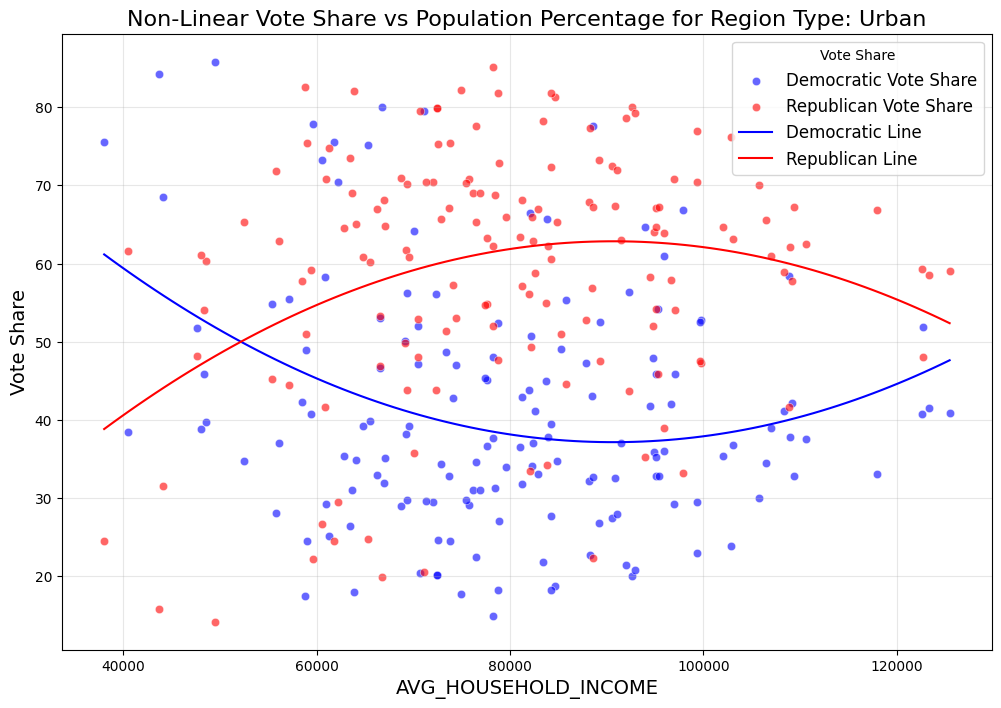

In [87]:
plot_vote_share_vs_population(
    df=sc_income_pop_vote_share_df,
    population_col='AVG_HOUSEHOLD_INCOME',
    dem_col='DEMOCRATIC_VOTE_SHARE',
    rep_col='REPUBLICAN_VOTE_SHARE',
    region_type='urban',
    degree=2
)

# Maryland

In [59]:
md_election_gov_df = pd.read_json('states/maryland/election/md_election_gov_22.json')
md_race_df = pd.read_json('states/maryland/demographics/maryland_precincts_racial_population.json')
md_region_type_df = pd.read_json('states/maryland/geodata/maryland_precincts_region_type.json')
md_econ_df = pd.read_json('states/maryland/economic/maryland_precincts_household_income.json')

In [60]:
md_region_type_df = md_region_type_df.rename(columns={'region_type': 'REGION_TYPE'})

In [ ]:
md_white_pop_vote_share_df = process_population_vote_share(md_race_df, md_election_gov_df, md_region_type_df, md_econ_df, 'WHITE_PERCENT', 'WHT_NHSP22')
md_black_pop_vote_share_df = process_population_vote_share(md_race_df, md_election_gov_df, md_region_type_df, md_econ_df, 'BLACK_PERCENT', 'BLK_NHSP22')
md_asian_pop_vote_share_df = process_population_vote_share(md_race_df, md_election_gov_df, md_region_type_df, md_econ_df, 'ASIAN_PERCENT', 'ASN_NHSP22')
md_hispanic_pop_vote_share_df = process_population_vote_share(md_race_df, md_election_gov_df, md_region_type_df, md_econ_df, 'HISPANIC_PERCENT', 'HPI_NHSP22')
md_income_pop_vote_share_df = process_income_vote_share(sc_election_gov_df, sc_region_type_df, sc_econ_df)

In [62]:
# plot_vote_share_vs_population(
#     df=md_black_pop_vote_share_df,
#     population_col='Black_Pop_Percent',
#     dem_col='Democratic_Vote_Share',
#     rep_col='Republican_Vote_Share',
#     degree=2
# )

In [63]:
md_white_pop_vote_share_list = md_white_pop_vote_share_df.to_dict(orient='records')
md_black_pop_vote_share_list = md_black_pop_vote_share_df.to_dict(orient='records')
md_asian_pop_vote_share_list = md_asian_pop_vote_share_df.to_dict(orient='records')
md_hispanic_pop_vote_share_list = md_hispanic_pop_vote_share_df.to_dict(orient='records')

output_data = {
    "NAME": "Maryland",
    "election": "2022 Gubernatorial Elections",
    "candidates": {
        "Republican": "Dan Cox",
        "Democratic": "Wes Moore"
    },
    "data": {
        "WHITE": md_white_pop_vote_share_list,
        "BLACK": md_black_pop_vote_share_list,
        "ASIAN": md_asian_pop_vote_share_list,
        "HISPANIC": md_hispanic_pop_vote_share_list
    }
}

In [64]:
output_json = json.dumps(output_data, indent=4)
open ('states/maryland/gingles/md_gingles_precinct_analysis.json', 'w').write(output_json)

1679495